Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [59]:
import os
import torch
import torchaudio
import tarfile
import wandb
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from sklearn.utils.class_weight import compute_class_weight


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [60]:
project_name='TP3-TD6'
username = "sansonmariano-universidad-torcuato-di-tella"
wandb.login(key="d2875c91a36209496ee81454cccd95ebe3dc948d")
wandb.init(project = project_name, entity = username)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▂▅▃▃▄▁▃▅▆▅▃▁▂▃▂▆█▂▄▂▆▇▁▃▁▆▆█▂▃▄▆█▁▇▆█▂▂▇
train_loss,█▃▂▃▁▁█▁▁▂▁▁▆▅▃▁▁█▂▁▁▄█▇▅█▁▃▇█▅▁▁▇▁█▆▄█▄
val_loss,▂▂▁▁▂▂▂▂▃▃▁▂▂▃▁▅▁▂▁▄▅▇▁▁▃▆▁▃▆█▃▄▅▁▁█▁▃▃▆
epoch,10
train_loss,1.07991
val_loss,4.37085


In [61]:
random_seed = 42

torch.manual_seed(random_seed)

# Definir parámetros
samplerate = 22050
data_dir = './genres_5sec'

init_batch_size = 20
init_num_epochs = 10
init_lr = 0.0005

In [62]:
# Función para parsear géneros
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts

# Definir la clase del dataset
class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files = []
        for c in os.listdir(root):
            self.files += [os.path.join(root, c, fname) for fname in os.listdir(os.path.join(root, c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]
        genre = parse_genres(fpath)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        return audio, class_idx

In [68]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el dataset
dataset = MusicDataset(data_dir)

# Ensure labels match the number of samples
# Adjust if 'targets' is not the correct attribute
labels = dataset.classes if hasattr(dataset, 'targets') else [dataset[i][1] for i in range(len(dataset))]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# First, split into training (70%) and temp (30% for val + test)
for train_idx, temp_idx in split.split(range(len(dataset)), labels):
    train_dataset = Subset(dataset, train_idx)
    temp_dataset = Subset(dataset, temp_idx)

# Next, split the temp dataset (30%) into validation (15%) and test (15%)
val_test_labels = [labels[i] for i in temp_idx]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in split.split(temp_idx, val_test_labels):
    val_dataset = Subset(dataset, [temp_idx[i] for i in val_idx])
    test_dataset = Subset(dataset, [temp_idx[i] for i in test_idx])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=init_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=init_batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=init_batch_size, shuffle=True, num_workers=0)


In [69]:
list_files=os.listdir(data_dir)

classes=[]

for file in list_files:

  name='{}/{}'.format(data_dir,file)

  if os.path.isdir(name):

    classes.append(file)

### 3. Visualización de los archivos

In [42]:
waveform,label= dataset[0]

print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 4 


shape of spectogram torch.Size([1, 201, 552])


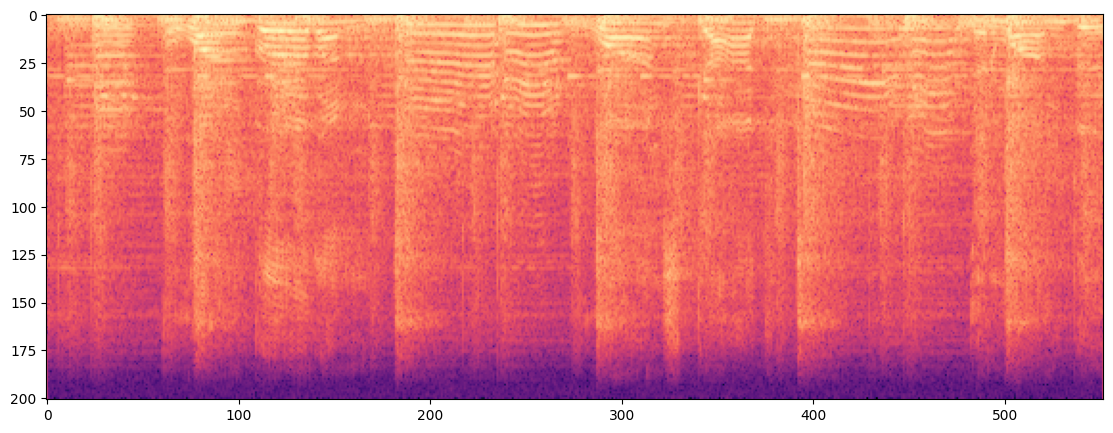

In [43]:
specgram = tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.1055, -0.1083, -0.1056]])



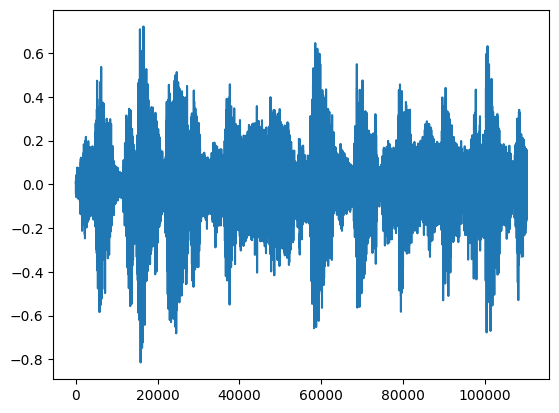

In [44]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [45]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

### 4. Clasificación

In [70]:
class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=64, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_output)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        x = self.fc3(x)          # Output layer, no activation as it's used for logits
        return x

In [72]:
# Inicializar el modelo
input_size = samplerate * 5  # Asumiendo que tomas 5 segundos de audio
num_classes = len(dataset.classes)
model = MLP(input_size)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (fc1): Linear(in_features=110250, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [75]:
import gc

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
valid_losses = []
num_epochs = 10
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
for epoch in range(num_epochs):
    losses = []

    # Train
    model.train()
    for wav, genre_index in train_loader:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        #M5
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in val_loader:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = loss_function(out.squeeze(), genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(val_loader.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

Epoch: [1/10], Train loss: 0.0202
Epoch: [1/10], Valid loss: 3.2094, Valid accuracy: 0.1959
Saving the best model at 0 epochs!
Epoch: [2/10], Train loss: 0.0066
Epoch: [2/10], Valid loss: 3.3924, Valid accuracy: 0.1689
Epoch: [3/10], Train loss: 0.0071
Epoch: [3/10], Valid loss: 3.7449, Valid accuracy: 0.1757
Epoch: [4/10], Train loss: 0.0035
Epoch: [4/10], Valid loss: 3.6894, Valid accuracy: 0.1824
Epoch: [5/10], Train loss: 0.0026
Epoch: [5/10], Valid loss: 3.7592, Valid accuracy: 0.1824
Epoch: [6/10], Train loss: 0.0022
Epoch: [6/10], Valid loss: 3.8713, Valid accuracy: 0.1824
Epoch: [7/10], Train loss: 0.0029
Epoch: [7/10], Valid loss: 3.9580, Valid accuracy: 0.1757
Epoch: [8/10], Train loss: 0.0025
Epoch: [8/10], Valid loss: 3.8370, Valid accuracy: 0.1757
Epoch: [9/10], Train loss: 0.0024
Epoch: [9/10], Valid loss: 4.0123, Valid accuracy: 0.1757
Epoch: [10/10], Train loss: 0.0023
Epoch: [10/10], Valid loss: 3.9800, Valid accuracy: 0.1757


In [77]:
# Evaluación en el conjunto de test
model.eval()
test_loss = 0.0
correct = 0
total = len(test_dataset)

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size = init_batch_size, shuffle=False):

        outputs = model(inputs).squeeze(1)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.2168, Test Accuracy: 8.72%


In [78]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Define a model class to experiment with different architectures
class ExperimentNN(nn.Module):
    def __init__(self, input_size, num_classes, layer_size, layers):
        super(ExperimentNN, self).__init__()
        self.layer_sizes = layer_size
        self.activation_function = F.relu
        self.fc_layers = nn.ModuleList()

        for layer in range(layers-1):
            if (layer == 0):
                self.fc_layers.append(nn.Linear(input_size, layer_size))
            else:
                self.fc_layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.fc_layers.append(nn.Linear(layer_size, num_classes))

    def forward(self, x):
        for fc in self.fc_layers[:-1]:  # Skip last layer
            x = F.relu(fc(x))

        x = self.fc_layers[-1](x)  # Output layer (no activation)
        return x


def train_model(model, criterion, optimizer, epochs):

    best_loss = float("inf")
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(1), labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Logging to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        # Clear cache and collect garbage
        gc.collect()
        torch.cuda.empty_cache()

        if val_loss < best_loss:
            best_loss = val_loss
    
    return best_loss

# Define the search space for hyperopt
layers = [2,3,5,6,9]

sizes = [32,64,128,256]

best_val_loss = float("inf")
learning_rate = init_lr
weight_decay = 1e-4

best_model = None

for layer in layers:
    for size in sizes:
        # Initialize the model
        model = ExperimentNN(input_size, num_classes, size, layer).to(device)

        # Set the criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        validation_loss = train_model(model, criterion, optimizer, init_num_epochs)

        print(f"val loss: {validation_loss}, for {layer} layers and layer size: {size}")

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model = model

print(f"Best model: {best_model}, validation loss: {best_val_loss}")

val loss: 2.291267365217209, for 2 layers and layer size: 32
val loss: 2.309815764427185, for 2 layers and layer size: 64
val loss: 2.350921392440796, for 2 layers and layer size: 128
val loss: 2.4050648510456085, for 2 layers and layer size: 256
val loss: 2.2834887206554413, for 3 layers and layer size: 32
val loss: 2.245402365922928, for 3 layers and layer size: 64
val loss: 2.232895016670227, for 3 layers and layer size: 128
val loss: 2.2026494443416595, for 3 layers and layer size: 256
val loss: 2.2466991245746613, for 5 layers and layer size: 32
val loss: 2.2361532747745514, for 5 layers and layer size: 64
val loss: 2.230749547481537, for 5 layers and layer size: 128
val loss: 2.1959167569875717, for 5 layers and layer size: 256
val loss: 2.28564316034317, for 6 layers and layer size: 32
val loss: 2.229599118232727, for 6 layers and layer size: 64
val loss: 2.2390552163124084, for 6 layers and layer size: 128
val loss: 2.20683191716671, for 6 layers and layer size: 256
val loss: 2

In [51]:
# Evaluación en el conjunto de test
model.eval()
test_loss = 0.0
correct = 0
total = len(test_dataset)

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size = init_batch_size, shuffle=False):

        outputs = model(inputs).squeeze(1)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.2020, Test Accuracy: 9.40%


In [52]:
def audio_to_spectrogram(waveform):
    # Ensure the waveform is in the correct shape
    if len(waveform.shape) == 1:
        waveform = waveform.unsqueeze(0)
    
    # Convert the waveform to a spectrogram
    spectrogram = tt.Spectrogram()(waveform)
    return spectrogram

In [53]:
waveform,label= dataset[0]

spec = audio_to_spectrogram(waveform)

spec.shape

torch.Size([1, 201, 552])

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 output channels
        
        # Calculate the size after convolutions and pooling
        # Assuming we apply max pooling of 2x2 after each convolution
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Input size = (201, 552)
        # After 3 convolutions + 3 max pooling, the output size will be:
        # Conv1: (201, 552) -> Pool1: (101, 276)
        # Conv2: (101, 276) -> Pool2: (50, 138)
        # Conv3: (50, 138) -> Pool3: (25, 69)
        # Output features from conv3 will be 128 * 25 * 69
        self.fc1 = nn.Linear(128 * 25 * 69, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, num_classes)     # Output layer

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Apply conv1 and pool
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Apply conv2 and pool
        x = self.pool(F.leaky_relu(self.conv3(x)))  # Apply conv3 and pool
        x = torch.flatten(x, 1)                      # Flatten the output for the fully connected layers
        x = F.leaky_relu(self.fc1(x))                # Apply first fully connected layer
        x = self.fc2(x)                              # Apply output layer
        return x

In [55]:
def train_model_CNN(model, criterion, optimizer, epochs):

    best_loss = float("inf")
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        i = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = audio_to_spectrogram(inputs)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(1), labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Logging to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        # Clear cache and collect garbage
        gc.collect()
        torch.cuda.empty_cache()

        if val_loss < best_loss:
            best_loss = val_loss

        i += 1
    
    return best_loss

In [56]:
# Define the search space for hyperopt
layers = [2,3,5,6,9]

sizes = [32,64,128,256]

best_val_loss = float("inf")
learning_rate = init_lr
weight_decay = 1e-4

best_model = None

for layer in layers:
    for size in sizes:
        # Initialize the model
        model = CNN(10).to(device)

        # Set the criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        validation_loss = train_model_CNN(model, criterion, optimizer, init_num_epochs)

        print(f"val loss: {validation_loss}, for {layer} layers and layer size: {size}")

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model = model

print(f"Best model: {best_model}, validation loss: {best_val_loss}")

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 20, 1, 110250] to have 1 channels, but got 20 channels instead

In [59]:
# Define a model class to experiment with different architectures
class ExperimentNNActivation(nn.Module):
    def __init__(self, input_size=110250, num_classes=10, layer_size=128, layers=6, activation='relu'):
        super(ExperimentNNActivation, self).__init__()
        self.layer_sizes = layer_size
        self.fc_layers = nn.ModuleList()
        
        # Choose the activation function based on the input parameter
        if activation == 'relu':
            self.activation_function = F.relu
        elif activation == 'leaky_relu':
            self.activation_function = F.leaky_relu
        elif activation == 'sigmoid':
            self.activation_function = F.sigmoid
        elif activation == 'tanh':
            self.activation_function = F.tanh
        else:
            raise ValueError("Unsupported activation function.")

        # Create fully connected layers
        for layer in range(layers - 1):
            if layer == 0:
                self.fc_layers.append(nn.Linear(input_size, layer_size))
            else:
                self.fc_layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.fc_layers.append(nn.Linear(layer_size, num_classes))

    def forward(self, x):
        for layer in self.fc_layers[:-1]:  # Loop through all layers except the last one
            x = self.activation_function(layer(x))  # Apply activation function
        x = self.fc_layers[-1](x)  # Output layer, no activation function here
        return x

activation_functions = ["relu", "leaky_relu", "sigmoid", "tanh"]

best_val_loss = float("inf")
learning_rate = init_lr
weight_decay = 1e-4

best_model = None

for f_act in activation_functions:

    # Initialize the model
    model = ExperimentNNActivation(activation = f_act).to(device)

    # Set the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    validation_loss = train_model(model, criterion, optimizer, init_num_epochs)

    print(f"val loss: {validation_loss}, for 4 layers and layer size: 128")

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_model = model

print(f"Best model: {best_model}, validation loss: {best_val_loss}")


val loss: 2.294156849384308, for 2 layers and layer size: 32
val loss: 2.291288286447525, for 2 layers and layer size: 32
val loss: 2.312764048576355, for 2 layers and layer size: 32
val loss: 2.297784775495529, for 2 layers and layer size: 32
Best model: ExperimentNNActivation(
  (fc_layers): ModuleList(
    (0): Linear(in_features=110250, out_features=128, bias=True)
    (1-4): 4 x Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
), validation loss: 2.291288286447525


In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a model class to experiment with different architectures
class ExperimentNNBatchEpoch(nn.Module):
    def __init__(self, input_size=110250, num_classes=10, layer_size=128, layers=4):
        super(ExperimentNNBatchEpoch, self).__init__()
        
        # Initialize a list to hold the fully connected layers
        self.fc_layers = nn.ModuleList()
        
        # Add the first layer, connecting input to the first hidden layer
        self.fc_layers.append(nn.Linear(input_size, layer_size))
        
        # Add hidden layers with 128 nodes each
        for _ in range(layers):  # Already have input and output layers, so add (layers - 2) hidden layers
            self.fc_layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.fc_layers.append(nn.Linear(layer_size, num_classes))

    def forward(self, x):
        # Apply Leaky ReLU activation to each layer except the output layer
        for fc in self.fc_layers[:-1]:  # Skip last layer
            x = F.leaky_relu(fc(x))
        
        x = self.fc_layers[-1](x)  # Output layer (no activation)
        return x

In [67]:
import gc
import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define a function to train the model with different configurations
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    best_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(1), labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Logging to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        # Clear cache and collect garbage
        gc.collect()
        torch.cuda.empty_cache()

        if val_loss < best_loss:
            best_loss = val_loss
    
    return best_loss

batch_sizes = [16, 32, 64, 128]  # Different batch sizes to test
epoch_counts = [10, 20, 30]  # Different epoch counts to test

# Set initial parameters
best_val_loss = float("inf")
learning_rate = init_lr
weight_decay = 1e-4
best_model = None

for batch_size in batch_sizes:
    for epochs in epoch_counts:
        # Initialize the model
        model = ExperimentNNBatchEpoch().to(device)
        
        # Set the criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Create data loaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Train the model
        validation_loss = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)
        
        print(f"Val loss: {validation_loss}, Layers: 4, Layer size: 128, Batch size: {batch_size}, Epochs: {epochs}")
        
        # Save the best model
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model = model

print(f"Best model: {best_model}, validation loss: {best_val_loss}")


Val loss: 2.2540167808532714, Layers: 2, Layer size: 32, Batch size: 16, Epochs: 10
Val loss: 2.29056077003479, Layers: 2, Layer size: 32, Batch size: 16, Epochs: 20
Val loss: 2.2765111207962034, Layers: 2, Layer size: 32, Batch size: 16, Epochs: 30
Val loss: 2.264615058898926, Layers: 2, Layer size: 32, Batch size: 32, Epochs: 10
Val loss: 2.2798335552215576, Layers: 2, Layer size: 32, Batch size: 32, Epochs: 20
Val loss: 2.2765505790710447, Layers: 2, Layer size: 32, Batch size: 32, Epochs: 30
Val loss: 2.2896424929300943, Layers: 2, Layer size: 32, Batch size: 64, Epochs: 10
Val loss: 2.2792933781941733, Layers: 2, Layer size: 32, Batch size: 64, Epochs: 20
Val loss: 2.2822678089141846, Layers: 2, Layer size: 32, Batch size: 64, Epochs: 30
Val loss: 2.2733877897262573, Layers: 2, Layer size: 32, Batch size: 128, Epochs: 10
Val loss: 2.2304275035858154, Layers: 2, Layer size: 32, Batch size: 128, Epochs: 20
Val loss: 2.2860429286956787, Layers: 2, Layer size: 32, Batch size: 128, Epo

In [69]:
import gc
import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define a function to train the model with different configurations
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    best_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Step the scheduler, if provided
        if scheduler:
            scheduler.step()

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(1), labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Logging to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        # Clear cache and collect garbage
        gc.collect()
        torch.cuda.empty_cache()

        if val_loss < best_loss:
            best_loss = val_loss
    
    return best_loss

# Best batch size and epoch count from previous testing
best_batch_size = 128 # Replace with the best batch size
best_epoch_count = 20  # Replace with the best epoch count

# Initialize parameters for optimizer and scheduler search
best_val_loss = float("inf")
learning_rate = init_lr
weight_decay = 1e-4
best_model = None

# Define a list of optimizers and schedulers to test
optimizers = [
    lambda model: torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
    lambda model: torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    lambda model: torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
]

schedulers = [
    None,  # No scheduler
    lambda opt: torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1),
    lambda opt: torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9),
    lambda opt: torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
]

# Data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Iterate through optimizer and scheduler combinations
for optimizer_fn in optimizers:
    for scheduler_fn in schedulers:
        # Initialize model, optimizer, and scheduler
        model = ExperimentNNBatchEpoch().to(device)
        optimizer = optimizer_fn(model)
        scheduler = scheduler_fn(optimizer) if scheduler_fn else None

        # Train the model
        validation_loss = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, best_epoch_count)
        
        # Print results for this combination
        optimizer_name = optimizer.__class__.__name__
        scheduler_name = scheduler.__class__.__name__ if scheduler else "None"
        print(f"Val loss: {validation_loss}, Optimizer: {optimizer_name}, Scheduler: {scheduler_name}")
        
        # Save the best model
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model = model

print(f"Best model: {best_model}, validation loss: {best_val_loss}")


Val loss: 2.2709449529647827, Optimizer: Adam, Scheduler: None
Val loss: 2.261636257171631, Optimizer: Adam, Scheduler: StepLR
Val loss: 2.276898980140686, Optimizer: Adam, Scheduler: ExponentialLR
Val loss: 2.238691568374634, Optimizer: Adam, Scheduler: CosineAnnealingLR
Val loss: 2.302635431289673, Optimizer: SGD, Scheduler: None
Val loss: 2.3050127029418945, Optimizer: SGD, Scheduler: StepLR
Val loss: 2.303089737892151, Optimizer: SGD, Scheduler: ExponentialLR
Val loss: 2.3029574155807495, Optimizer: SGD, Scheduler: CosineAnnealingLR
Val loss: 2.212365508079529, Optimizer: AdamW, Scheduler: None
Val loss: 2.2666566371917725, Optimizer: AdamW, Scheduler: StepLR
Val loss: 2.260323643684387, Optimizer: AdamW, Scheduler: ExponentialLR
Val loss: 2.2831250429153442, Optimizer: AdamW, Scheduler: CosineAnnealingLR
Best model: ExperimentNNBatchEpoch(
  (fc_layers): ModuleList(
    (0): Linear(in_features=110250, out_features=128, bias=True)
    (1-4): 4 x Linear(in_features=128, out_features

In [70]:
# Evaluación en el conjunto de test
best_model.eval()
test_loss = 0.0
correct = 0
total = len(test_dataset)

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size = init_batch_size, shuffle=False):
        outputs = model(inputs).squeeze(1)

        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.1986, Test Accuracy: 7.05%


In [71]:
count = 0

for i in range(0,len(test_dataset)):
    waveform,label= test_dataset.dataset[i]

    wav= torch.unsqueeze(waveform, dim=0)
    model.to(device)
    wav =wav.to(device)
    out = model(wav)
    pred= out.argmax(dim=-1).flatten()

    clase_predicha = classes[pred]

    clase_verdadera = classes[label]

    if clase_predicha == clase_verdadera:
        count+=1

    print(clase_predicha, clase_verdadera)

print(count/len(test_dataset))

reggae blues
blues blues
disco blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
reggae blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
reggae blues
blues blues
blues blues
reggae blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
pop blues
reggae blues
reggae blues
reggae blues
blues blues
blues blues
blues blues
blues blues
disco blues
blues blues
blues blues
blues blues
reggae blues
blues blues
blues blues
reggae blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
metal blues
hiphop blues
blues blues
blues blues
reggae blues
blues blues
reggae blues
blues blues
blues blues
blues blues
blues blues
blues blues
reggae blues
blues blues
blues blues
blues blues
reggae blues
blues blues
blues blues
reggae blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
reg